In [1]:
#Библиотеки для работы с данными
import numpy as np
import pandas as pd
#Для построения и работы с графиками
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
#Для работы с моделями
import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#Для оценки результатов обучения модели
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from livelossplot.tf_keras import PlotLossesCallback
#Контроль над скоростью обучения
from keras.callbacks import LearningRateScheduler
#Для работы с изображениями
import cv2
from PIL import Image
#Для взаимодействия с ОС
import os

2024-08-28 15:01:15.963128: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Подтянем директории с файлами для обучения
#Тренировочная часть
train_dir = './data/emotion_recog_data/train'
#Публичная тестовая часть датасета
test_dir = './data/emotion_recog_data/test'

In [3]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input

BATCH_SIZE = 100
IMG_SHAPE  = 224


#Обучение и валидация:
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   rescale = 1./255,
                                   validation_split = 0.2,
                                   preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, preprocessing_function=preprocess_input)

#Тестирование результатов (здесь нужно применить только rescale и preprocess):
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_input)

#Теперь сгенерируем датасет на основе заданных ранее параметров:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_SHAPE ,IMG_SHAPE),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = val_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_SHAPE ,IMG_SHAPE),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = './data/emotion_recog_data/',
                                                    target_size = (IMG_SHAPE ,IMG_SHAPE),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    seed = 12,
                                                    classes=['test']
                                                  )

Found 40040 images belonging to 9 classes.
Found 10007 images belonging to 9 classes.
Found 5000 images belonging to 1 classes.


## Model evaluation

In [4]:
#Загрузим модель из чекпойнта
model = tf.keras.models.load_model("checkpoints/emotion_recog/best_model.h5")

2024-08-28 15:01:21.184879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-28 15:01:21.196882: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-28 15:01:21.196916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-28 15:01:21.198884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-28 15:01:21.198917: I tensorflow/compile

In [5]:
#Проверим, выведя структуру модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               12845184  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 9)                 297       
                                                                 
Total params: 36420617 (138.93 MB)
Trainable params: 128

In [6]:
#Проверка текущих результатов:
model.evaluate(validation_generator)

2024-08-28 15:01:23.199352: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-08-28 15:01:23.770124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


101/101 [==============================] - 24s 213ms/step - loss: 1.9056 - categorical_accuracy: 0.3060


[1.9056217670440674, 0.30598580837249756]

Детальнее посмотрим на результаты нашей модели. Начнем с того, что выведем предсказание по случайному батчу из валидационного сета:

In [7]:
#Для этого напишем функцию, выведем несколько изображений и их предсказания, а также правильные ярлыки на экран:
def show_images_preds(images, labels, predicted_labels=None):
    names = dict((v,k) for k,v in train_generator.class_indices.items()) #подтянем названия классов по их нумерации в датагене
    plt.figure(figsize=(10,8))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    #Выведем 9 изображений по 3 в каждом ряду:
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img = images[i]
        #Нормализация цвета для текущего изображения:
        img = ((img-img.min()) / (img.max()- img.min())) * 255
        img = Image.fromarray(img.astype(np.uint8))
        plt.imshow(img)
        #Настройка отображения ярлыков
        if predicted_labels is not None:
            real_label = labels[i].argmax()
            title_obj = plt.title(f"Real: {names[real_label]}. Pred: {names[predicted_labels[i]]}")
            #Если предсказанный ярлык не совпадает с фактическим, цвет текста поменяем на красный:
            if real_label != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[labels[i]]}")

4/4 [==============================] - 2s 192ms/step


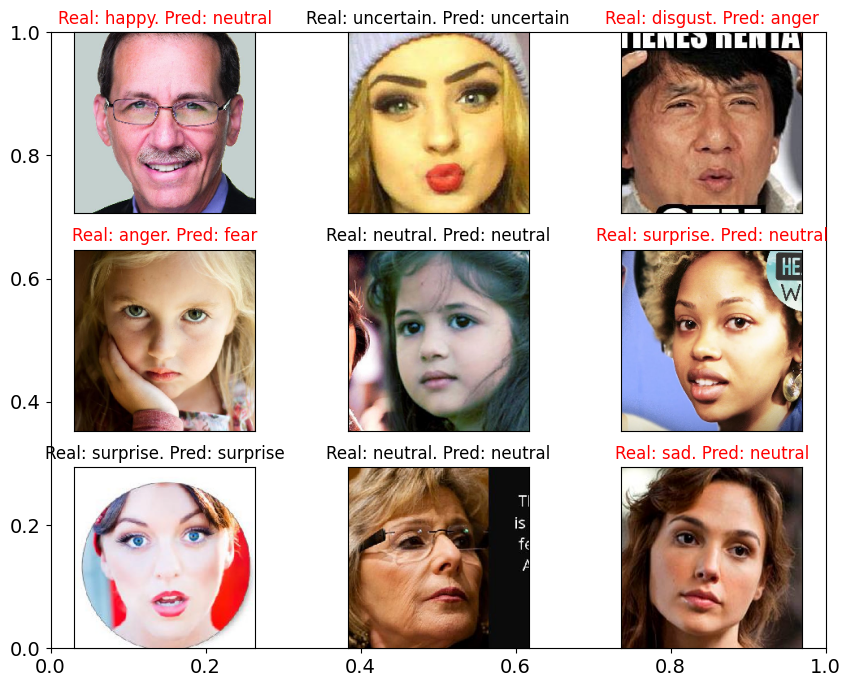

In [8]:
#Опробуем на случайном батче
sample_validation_images, sample_validation_labels = validation_generator[10]
predicted = model.predict(sample_validation_images).argmax(axis=1)
show_images_preds(sample_validation_images, sample_validation_labels, predicted)

In [9]:
# Также выведем так называемую матрицу ошибок, чтобы детальнее оценить масштабы бедствия/успеха:
preds = model.predict(validation_generator)
y_pred = np.argmax(preds , axis = 1 )
y_test = np.array(validation_generator.labels)

101/101 [==============================] - 21s 208ms/step


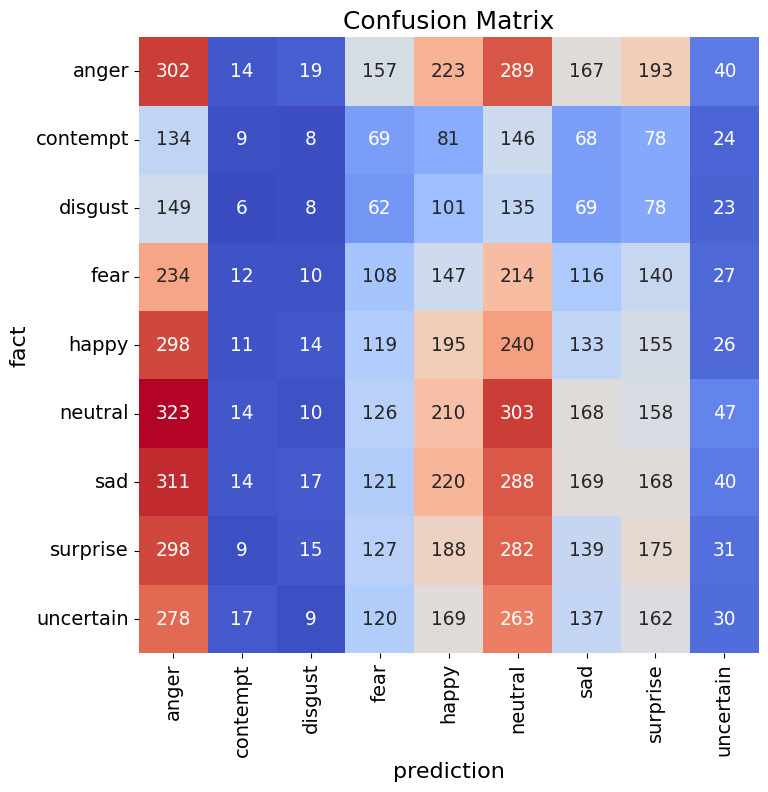

In [10]:
#Функция для отображения
def show_conf_matrix(y_test, y_pred, subset=None, cmap = "coolwarm", figsize = (8,8)):
    if subset is not None:
        cm_data = confusion_matrix(y_test , y_pred, labels=subset)
        names = dict((v,k) for k,v in train_generator.class_indices.items())
        cm_labels = [names[i] for i in subset]
    else:
        cm_labels = list(train_generator.class_indices.keys())
        cm_data = confusion_matrix(y_test , y_pred)
    
    cm = pd.DataFrame(cm_data, columns=cm_labels, index = cm_labels)
    cm.index.name = 'fact'
    cm.columns.name = 'prediction'
    plt.figure(figsize = figsize)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.xlabel('fact', fontsize=16)
    plt.ylabel('prediction', fontsize=16)
    plt.title('Confusion Matrix', fontsize = 18)
    ax = sns.heatmap(cm, cbar=False, cmap = cmap, annot=True, fmt='g', cbar_kws={'label': 'Scale'}, annot_kws={"size":40 / np.sqrt(len(cm))})
    
show_conf_matrix(y_test, y_pred)

Пришлось немного поиграться с цветами, чтобы отобразить такое большое количество объектов в более читаемом виде. В итоге было придумано следующее - чем теплее цвет, тем больше объектов было отнесено к данной категории, чем холоднее - тем меньше. Так становится чуть заметнее, что на точность модели всё-таки значительно влияет несбалансированность количества изображений по классам. Из=за этого модель более склонна относить изображение к классам "гнев (anger)" и "нейтральный (neutral)" и намного меньше - к классам "презрение (contempt)", "отвращение (disgust)","неопределённость (uncertain)".

Посмотрим на матрицу для эмоций гнев и нейтральная отдельно, чтобы оценить насколько хорошо модель определяет предсказания для наиболее "доминирующих" классов:

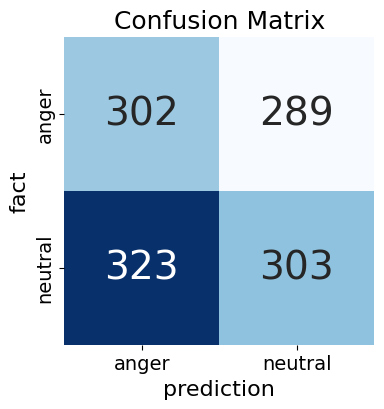

In [11]:
subset_labels = [0,5]
show_conf_matrix(y_test, y_pred, subset_labels, cmap = 'Blues', figsize = (4,4))

Можно сказать, что с задачей определения этих эмоций модель уже справляется сравнительно неплохо, хотя до идеала еще очень далеко.

In [12]:
#Наконец, посмотрим на classification report по модели:
names = list(train_generator.class_indices.keys())
print(classification_report(y_test, y_pred, target_names=names))

              precision    recall  f1-score   support

       anger       0.13      0.22      0.16      1404
    contempt       0.08      0.01      0.02       617
     disgust       0.07      0.01      0.02       631
        fear       0.11      0.11      0.11      1008
       happy       0.13      0.16      0.14      1191
     neutral       0.14      0.22      0.17      1359
         sad       0.14      0.13      0.13      1348
    surprise       0.13      0.14      0.14      1264
   uncertain       0.10      0.03      0.04      1185

    accuracy                           0.13     10007
   macro avg       0.12      0.11      0.10     10007
weighted avg       0.12      0.13      0.12     10007



Classification report подтвердил уже сделанные ранее выводы про несбалансированность обучающих данных и явно указал на необходимость  грамотно подойти к дообучению модели.

Изменение весов вслепую методом compute_class_weight бибилиотеки sklearn не принесло желательного результата. Прошерстив еще нменого литературы, я пришла к выводу, что имеет смысл дообучить нашу модель с учетом другой метрики - f1-score, т.к. она учитывает сразу precision и recall, а также чаще рекомендуется для задач классификации в целом и для задач классификации несбалансированных наборов данных в частности.

In [13]:
# Снова азморозим последний conv блок в нашей модели (слой 177 и дальше):
for layer in model.layers[0].layers[:177]:
    layer.trainable = False
for layer in model.layers[0].layers[177:]:
    layer.trainable = True

In [14]:
# Проверка статуса:
for i, layer in enumerate(model.layers[0].layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 pool1_pad False
4 pool1_pool False
5 conv2_block1_preact_bn False
6 conv2_block1_preact_relu False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_pad False
11 conv2_block1_2_conv False
12 conv2_block1_2_bn False
13 conv2_block1_2_relu False
14 conv2_block1_0_conv False
15 conv2_block1_3_conv False
16 conv2_block1_out False
17 conv2_block2_preact_bn False
18 conv2_block2_preact_relu False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_pad False
23 conv2_block2_2_conv False
24 conv2_block2_2_bn False
25 conv2_block2_2_relu False
26 conv2_block2_3_conv False
27 conv2_block2_out False
28 conv2_block3_preact_bn False
29 conv2_block3_preact_relu False
30 conv2_block3_1_conv False
31 conv2_block3_1_bn False
32 conv2_block3_1_relu False
33 conv2_block3_2_pad False
34 conv2_block3_2_conv False
35 conv2_block3_2_bn False
36 conv2_bloc

### Fine tuning

F1 score в качестве метрики для мониторинга оказалось не совсем просто реализовать на практике.

Для этого пришлось скачивать старую библиотеку tensorflow_addons, чтобы модель не ругалась на форму ввода.

Другие варианты  решения проблемы предполагали самостоятельную реализацию функции для данной метрики, что мне показалось не совсем разумным, учитывая что существует вполне себе рабочий вариант.

Для работы метрики с множественной (небинарной) классификацией необходимо, помимо прочего, указать метод усреднения показателей. Мы укажем метод качестве такого метода "macro" - простое арифметическое среднее всех значений f1 классов, не учитывающее вес самитх классов при вычислении. Данный метод наиболее логичен в случае работы с несбалансированным набором данных, где все классы одинаково важны.

In [15]:
import tensorflow_addons as tfa
f1 =tfa.metrics.F1Score(num_classes=9, average='macro')

/home/nette/miniconda3/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [16]:
initial_learning_rate = 0.05
final_learning_rate = 0.00005
EPOCHS = 500
STEPS_PER_EPOCH = 250
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/EPOCHS)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=STEPS_PER_EPOCH,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

lr = LearningRateScheduler(lr_schedule)

opt = keras.optimizers.Adam(learning_rate=initial_learning_rate)

In [17]:
model.compile(optimizer=opt,
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy(), f1])

#Чекпойнты:
plot_progress = PlotLossesCallback()
resnet_checkpoint = ModelCheckpoint('checkpoints/emotion_recog/ft3_block3.h5',monitor="val_f1_score",verbose=1, save_best_only=True, mode="max")
stopper = EarlyStopping(monitor = 'val_loss', verbose = 1, restore_best_weights=True, mode="min", patience = 10)

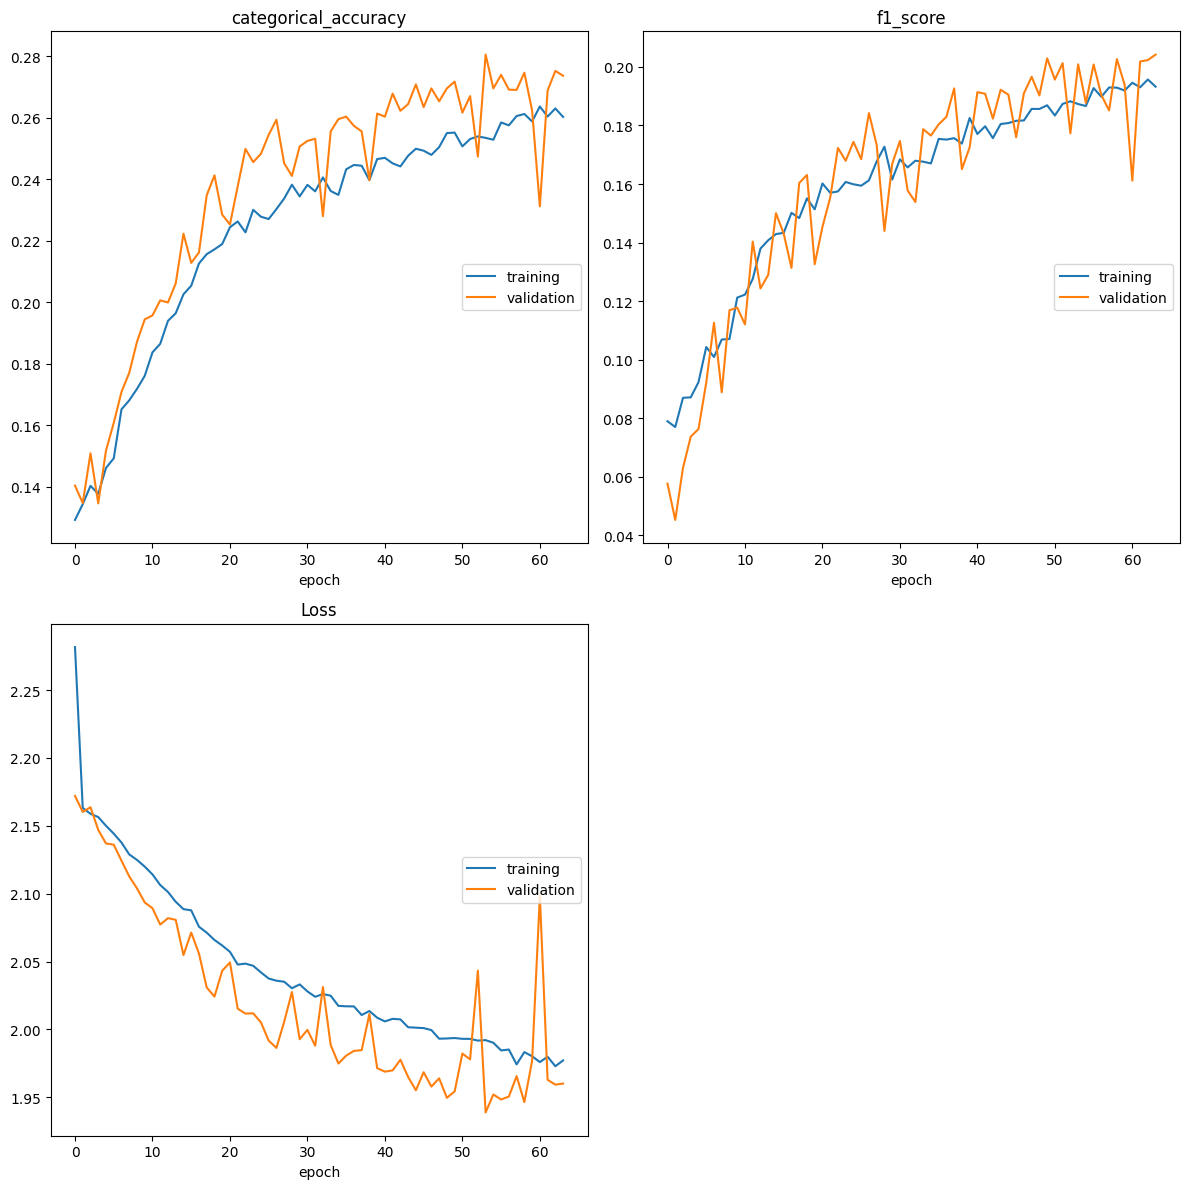

categorical_accuracy
	training         	 (min:    0.129, max:    0.264, cur:    0.260)
	validation       	 (min:    0.134, max:    0.281, cur:    0.274)
f1_score
	training         	 (min:    0.077, max:    0.196, cur:    0.193)
	validation       	 (min:    0.045, max:    0.204, cur:    0.204)
Loss
	training         	 (min:    1.973, max:    2.282, cur:    1.977)
	validation       	 (min:    1.939, max:    2.172, cur:    1.960)

Epoch 64: val_f1_score improved from 0.20293 to 0.20420, saving model to checkpoints/emotion_recog/ft3_block3.h5
Restoring model weights from the end of the best epoch: 54.
250/250 [==============================] - 142s 567ms/step - loss: 1.9772 - categorical_accuracy: 0.2603 - f1_score: 0.1933 - val_loss: 1.9601 - val_categorical_accuracy: 0.2737 - val_f1_score: 0.2042 - lr: 0.0100
Epoch 64: early stopping
CPU times: user 2h 55min 14s, sys: 1h 7s, total: 3h 55min 21s
Wall time: 2h 29min 41s


In [18]:
%%time


history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=100,
    validation_data=validation_generator,
    callbacks=[plot_progress, resnet_checkpoint, stopper, lr],
    verbose = True)

### Посмотрим, что у нас по итогу получилось:

In [19]:
#Загрузим модель из чекпойнта
model = tf.keras.models.load_model("checkpoints/emotion_recog/ft3_block3.h5")

In [20]:
#Проверка текущих результатов:
model.evaluate(validation_generator)

101/101 [==============================] - 22s 209ms/step - loss: 1.9601 - categorical_accuracy: 0.2735 - f1_score: 0.2041


[1.9600974321365356, 0.27350854873657227, 0.2040949910879135]

Как мы видим, точность модели повысилась примерно на 0.8% по сравнению с изначальным вариантом, что немного печально. Посмотрим что в итоге с остальными результатами. Удалось ли нам немного поменять ситуацию с точностью предсказания миноритарных классов?

4/4 [==============================] - 1s 159ms/step


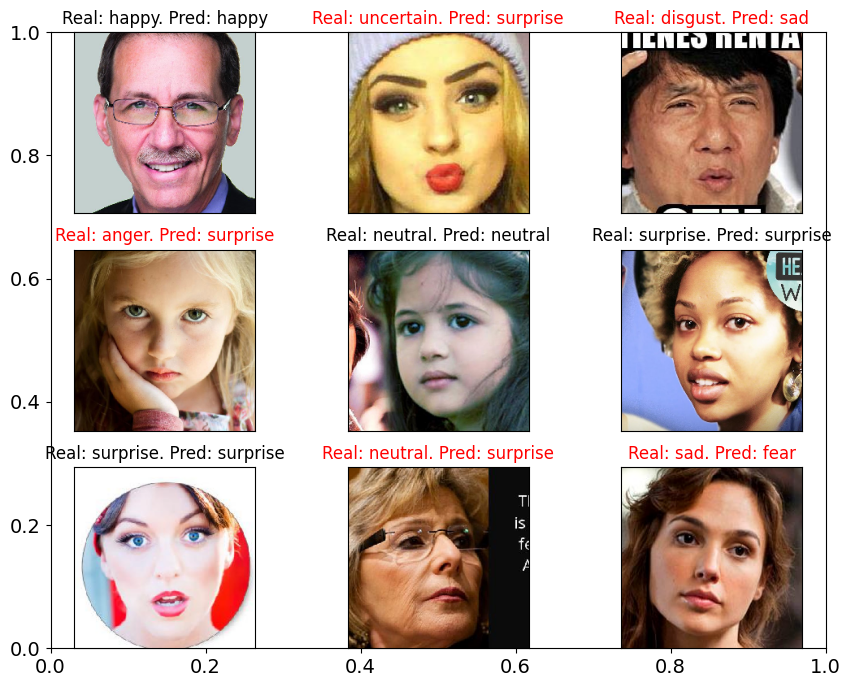

In [21]:
#Предсказание на батче изображений:
predicted = model.predict(sample_validation_images).argmax(axis=1)
show_images_preds(sample_validation_images, sample_validation_labels, predicted)

101/101 [==============================] - 22s 219ms/step


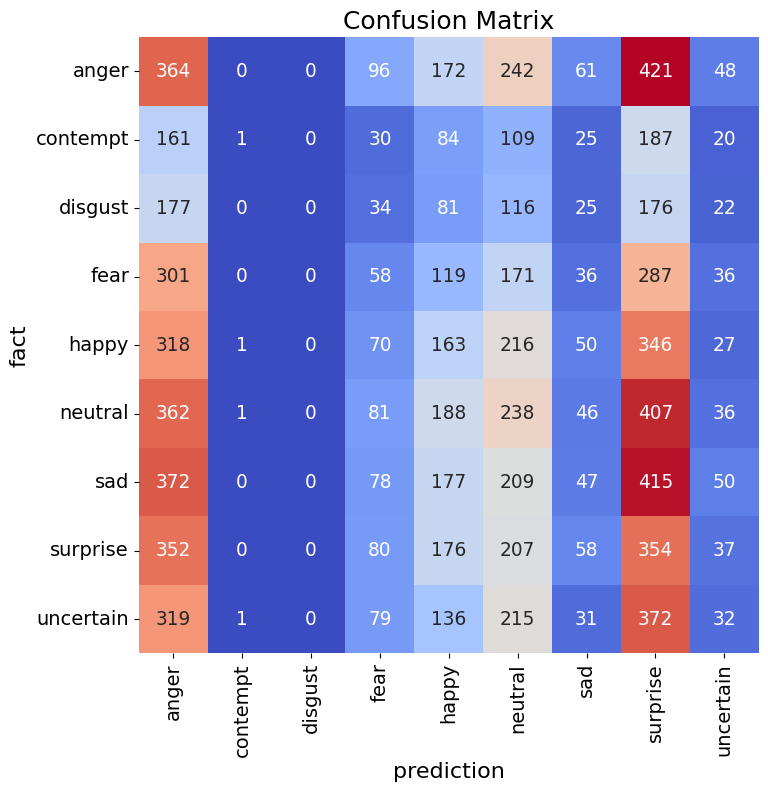

In [22]:
#Матрица ошибок
y_pred = np.argmax( model.predict(validation_generator), axis = 1)
show_conf_matrix(y_test, y_pred)

In [23]:
#И classification report:
names = list(train_generator.class_indices.keys())
print(classification_report(y_test, y_pred, target_names=names))

              precision    recall  f1-score   support

       anger       0.13      0.26      0.18      1404
    contempt       0.25      0.00      0.00       617
     disgust       0.00      0.00      0.00       631
        fear       0.10      0.06      0.07      1008
       happy       0.13      0.14      0.13      1191
     neutral       0.14      0.18      0.15      1359
         sad       0.12      0.03      0.05      1348
    surprise       0.12      0.28      0.17      1264
   uncertain       0.10      0.03      0.04      1185

    accuracy                           0.13     10007
   macro avg       0.12      0.11      0.09     10007
weighted avg       0.12      0.13      0.10     10007



/home/nette/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nette/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nette/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**По итогу имеем следующее:** подход к изменению весов модели оказался не самым лучшим. В результате мы получили модель, которая хуже предсказывает как классы с изначально большим весом, так и те, у которых вес изначально был минимальным. Более того, модель стала гораздо хуже определять экземпляры из последних классов - contempt, disgust и uncertain имеют почти нулевые показатели точности и полноты. 

Забавно, что при этом модель стала чуть лучше определять "печаль" на фотографиях. Об этом говорит так и заметное "потепление" цвета в этой области на матрице ошибок по сравнению с изначальной моделью, так и возросший показатель полноты ("recall"), что привело к росту индикатора f1 в категории. При этом заметно, что точность определения этой эмоции никак не поменялась (14% в обоих отчетах). Это сигнализирует о том, что проделанное нами ранее смещение весов привело лишь к тому, что модель стала чаще "пихать" фотографии в категорию sadness, а не в anger и neutral, как она делала это до переобучения. Также чуть увеличилась полнота предсказаний категорий "радость" и "удивление", что также не особо скзалось на увеличении точности предсказания по данным эмоциям конкретно и точности модели в целом. В общем, шалость не удалась. Попробуем переделать более вдумчиво.

In [ ]:
initial_lrate = 0.1
drop = 0.6
epochs_drop = 10.0
initial_lrate * math.pow(drop, math.floor((1+100)/epochs_drop))